In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import statistics
import os
import logging
from pathlib import Path
import sqlite3
%autosave 20

Autosaving every 20 seconds


In [8]:
gpu_data=pd.read_csv("./Documents/gpu.csv")
app_data=pd.read_csv("./Documents/application-checkpoints.csv")
task_data=pd.read_csv("./Documents/task-x-y.csv")

In [9]:
gpu_data.head(5)

,timestamp,hostname,gpuSerial,gpuUUID,powerDrawWatt,gpuTempC,gpuUtilPerc,gpuMemUtilPerc
0,2018-11-08T08:27:10.314Z,8b6a0eebc87b4cb2b0539e81075191b900001C,323217055910,GPU-1d1602dc-f615-a7c7-ab53-fb4a7a479534,131.55,48,92,53
1,2018-11-08T08:27:10.192Z,d8241877cd994572b46c861e5d144c85000000,323617020295,GPU-04a2dea7-f4f1-12d0-b94d-996446746e6f,117.03,40,92,48
2,2018-11-08T08:27:10.842Z,db871cd77a544e13bc791a64a0c8ed50000006,323217056562,GPU-f4597939-a0b4-e78a-2436-12dbab9a350f,121.64,45,91,44
3,2018-11-08T08:27:10.424Z,b9a1fa7ae2f74eb68f25f607980f97d7000010,325217085931,GPU-ad773c69-c386-a4be-b214-1ea4fc6045df,50.23,38,90,43
4,2018-11-08T08:27:10.937Z,db871cd77a544e13bc791a64a0c8ed50000003,323217056464,GPU-2d4eed64-4ca8-f12c-24bc-28f036493ea2,141.82,41,90,47


In [10]:
app_data.head(5)

,timestamp,hostname,eventName,eventType,jobId,taskId
0,2018-11-08T07:41:55.921Z,0d56a730076643d585f77e00d2d8521a00000N,Tiling,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,b47f0263-ba1c-48a7-8d29-4bf021b72043
1,2018-11-08T07:42:29.842Z,0d56a730076643d585f77e00d2d8521a00000N,Saving Config,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,20fb9fcf-a927-4a4b-a64c-70258b66b42d
2,2018-11-08T07:42:29.845Z,0d56a730076643d585f77e00d2d8521a00000N,Saving Config,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,20fb9fcf-a927-4a4b-a64c-70258b66b42d
3,2018-11-08T07:42:29.845Z,0d56a730076643d585f77e00d2d8521a00000N,Render,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,20fb9fcf-a927-4a4b-a64c-70258b66b42d
4,2018-11-08T07:43:13.957Z,0d56a730076643d585f77e00d2d8521a00000N,TotalRender,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,20fb9fcf-a927-4a4b-a64c-70258b66b42d


In [17]:
app_data.pivot_table('timestamp', ['hostname','eventName','jobId','taskId'], 'eventType')

DataError: No numeric types to aggregate

In [11]:
task_data.head(5)

,taskId,jobId,x,y,level
0,00004e77-304c-4fbd-88a1-1346ef947567,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,116,178,12
1,0002afb5-d05e-4da9-bd53-7b6dc19ea6d4,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,190,12
2,0003c380-4db9-49fb-8e1c-6f8ae466ad85,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,86,12
3,000993b6-fc88-489d-a4ca-0a44fd800bd3,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,235,11,12
4,000b158b-0ba3-4dca-bf5b-1b3bd5c28207,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,171,53,12


In [12]:
gpu_data.columns

Index(['timestamp', 'hostname', 'gpuSerial', 'gpuUUID', 'powerDrawWatt',
       'gpuTempC', 'gpuUtilPerc', 'gpuMemUtilPerc'],
      dtype='object')

In [13]:
app_data.columns

Index(['timestamp', 'hostname', 'eventName', 'eventType', 'jobId', 'taskId'], dtype='object')

In [14]:
task_data.columns

Index(['taskId', 'jobId', 'x', 'y', 'level'], dtype='object')

In [29]:
# merging the datasets to form a final dataset

TIMESTAMP_FORMAT = '%Y-%m-%dT%H:%M:%S.%fZ'

def timestamp_conversion(df):

    df = df.apply(lambda x: (datetime.strptime(x, TIMESTAMP_FORMAT)))    
    return(df)


def clean_gpu(gpu_df):

    gpu_df['timestamp'] = timestamp_conversion(gpu_df['timestamp'])
    return(gpu_df)

def merge_check_task(checkpoints_df, tasks_df):


    # Use left join on taskId and jobId

    check_task_df = checkpoints_df.merge(tasks_df,on=['taskId', 'jobId'], how='left')
    return (check_task_df)


def clean_check_task(check_task_df):

    # Fix date format
    
    check_task_df['timestamp'] = timestamp_conv(check_task_df['timestamp'])

    return(check_task_df)


def merge_check_task_gpu(gpu_df, check_task_df):

        
    # Record start and stop times for events and drop old timestamps

    check_task_df_start = check_task_df[
    check_task_df['eventType'] == 'START']
    check_task_df_stop = check_task_df[
    check_task_df['eventType'] == 'STOP']

    check_task_df_start.rename(index=str, columns={"timestamp": "start_time"}, inplace = True)
    check_task_df_stop.rename(index=str, columns={"timestamp": "stop_time"}, inplace = True)

    check_task_df_stop.drop('eventType', axis = 1, inplace = True)
    check_task_df_start.drop('eventType', axis = 1, inplace = True)
   
    # Make each field record start and stop combined
   
    check_task_df = pd.merge( check_task_df_start, check_task_df_stop,on=['hostname', 'eventName', 'x', 'y', 'level'])
   
    # Remove any timestamps that occur out of the gpu dataset
   
    check_task_df = check_task_df[
            (check_task_df['start_time'] >= gpu_df['timestamp'][0]) &
            (check_task_df['stop_time']
            <= gpu_df['timestamp'][len(gpu_df)-1])]
   
    # Use sqllite to only combine with gpu if timestamp is between times

    # connection to sql
    conn = sqlite3.connect(':memory:')

    # move dataframes to sql
    check_task_df.to_sql('CheckTask', conn, index=False)
    gpu_df.to_sql('Gpu', conn, index=False)

    # SQL query
    query = '''
    SELECT *
    FROM Gpu
    LEFT JOIN CheckTask ON gpu.hostname = CheckTask.hostname
    WHERE gpu.timestamp >= CheckTask.start_time 
        AND gpu.timestamp <= CheckTask.stop_time
    '''
    # get new df
    merged_df = pd.read_sql_query(query, conn)
    
    # drop duplicate hostname row (index 8)
    merged_df = merged_df.loc[:,~merged_df.columns.duplicated()]
    
    # group for averages (average stats for every task)
    
    functions = {
        'powerDrawWatt': 'mean', 'gpuTempC': 'mean',
        'gpuUtilPerc': 'mean', 'gpuMemUtilPerc': 'mean',
        'start_time': 'first', 'stop_time': 'first', 
        'gpuUUID' : 'first'}
    
    merged_df = merged_df.groupby(
        ['hostname', 'eventName', 'x', 'y', 'level'],
        as_index=False, sort=False
    ).agg(functions)

    return(merged_df)


gpu_df = pd.read_csv("./Documents/gpu.csv")
checkpoints_df = pd.read_csv("./Documents/application-checkpoints.csv")
tasks_df =pd.read_csv("./Documents/task-x-y.csv")
    
# Cleaning and merging process    
gpu_df = clean_gpu(gpu_df)
check_task_df = merge_check_task(checkpoints_df, tasks_df)
check_task_df = clean_check_task(check_task_df)  
final_df = merge_check_task_gpu(gpu_df, check_task_df)
final_df.head(5)

,hostname,eventName,x,y,level,powerDrawWatt,gpuTempC,gpuUtilPerc,gpuMemUtilPerc,start_time,stop_time,gpuUUID
0,0d56a730076643d585f77e00d2d8521a00000Q,TotalRender,156,186,12,96.807273,37.590909,70.318182,37.863636,2018-11-08 08:27:10.606000,2018-11-08 08:27:54.895000,GPU-d84a1024-9381-c725-3b85-dd7143e64c35
1,0d56a730076643d585f77e00d2d8521a00000Q,Render,156,186,12,96.807273,37.590909,70.318182,37.863636,2018-11-08 08:27:10.608000,2018-11-08 08:27:53.796000,GPU-d84a1024-9381-c725-3b85-dd7143e64c35
2,83ea61ac1ef54f27a3bf7bd0f41ecaa700000J,Uploading,200,23,12,42.440000,41.000000,0.000000,0.000000,2018-11-08 08:27:10.839000,2018-11-08 08:27:11.893000,GPU-8792a29c-529e-1837-1806-c669cd9b1960
3,83ea61ac1ef54f27a3bf7bd0f41ecaa700000J,Tiling,200,23,12,42.440000,41.000000,0.000000,0.000000,2018-11-08 08:27:10.846000,2018-11-08 08:27:11.882000,GPU-8792a29c-529e-1837-1806-c669cd9b1960
4,b9a1fa7ae2f74eb68f25f607980f97d700000H,TotalRender,160,14,12,91.566957,38.695652,71.000000,39.913043,2018-11-08 08:27:10.612000,2018-11-08 08:27:56.265000,GPU-38bbf3b6-80fb-7e6f-6678-ee45035507ab


In [170]:
TIMESTAMP_FORMAT = '%Y-%m-%d %H:%M:%S'


In [171]:
final_df['start']=pd.to_datetime(final_df['start_time'],format=TIMESTAMP_FORMAT, errors='ignore')
final_df['stop']=pd.to_datetime(final_df['stop_time'],format=TIMESTAMP_FORMAT, errors='ignore')

In [172]:
final_df.head(5)

,hostname,eventName,x,y,level,powerDrawWatt,gpuTempC,gpuUtilPerc,gpuMemUtilPerc,start_time,stop_time,gpuUUID,time_difference,start,stop
0,0d56a730076643d585f77e00d2d8521a00000Q,TotalRender,156,186,12,96.807273,37.590909,70.318182,37.863636,2018-11-08 08:27:10.606,2018-11-08 08:27:54.895,GPU-d84a1024-9381-c725-3b85-dd7143e64c35,44.0,2018-11-08 08:27:10.606,2018-11-08 08:27:54.895
1,0d56a730076643d585f77e00d2d8521a00000Q,Render,156,186,12,96.807273,37.590909,70.318182,37.863636,2018-11-08 08:27:10.608,2018-11-08 08:27:53.796,GPU-d84a1024-9381-c725-3b85-dd7143e64c35,43.0,2018-11-08 08:27:10.608,2018-11-08 08:27:53.796
2,83ea61ac1ef54f27a3bf7bd0f41ecaa700000J,Uploading,200,23,12,42.440000,41.000000,0.000000,0.000000,2018-11-08 08:27:10.839,2018-11-08 08:27:11.893,GPU-8792a29c-529e-1837-1806-c669cd9b1960,1.0,2018-11-08 08:27:10.839,2018-11-08 08:27:11.893
3,83ea61ac1ef54f27a3bf7bd0f41ecaa700000J,Tiling,200,23,12,42.440000,41.000000,0.000000,0.000000,2018-11-08 08:27:10.846,2018-11-08 08:27:11.882,GPU-8792a29c-529e-1837-1806-c669cd9b1960,1.0,2018-11-08 08:27:10.846,2018-11-08 08:27:11.882
4,b9a1fa7ae2f74eb68f25f607980f97d700000H,TotalRender,160,14,12,91.566957,38.695652,71.000000,39.913043,2018-11-08 08:27:10.612,2018-11-08 08:27:56.265,GPU-38bbf3b6-80fb-7e6f-6678-ee45035507ab,45.0,2018-11-08 08:27:10.612,2018-11-08 08:27:56.265


## Event types dominating task runtime

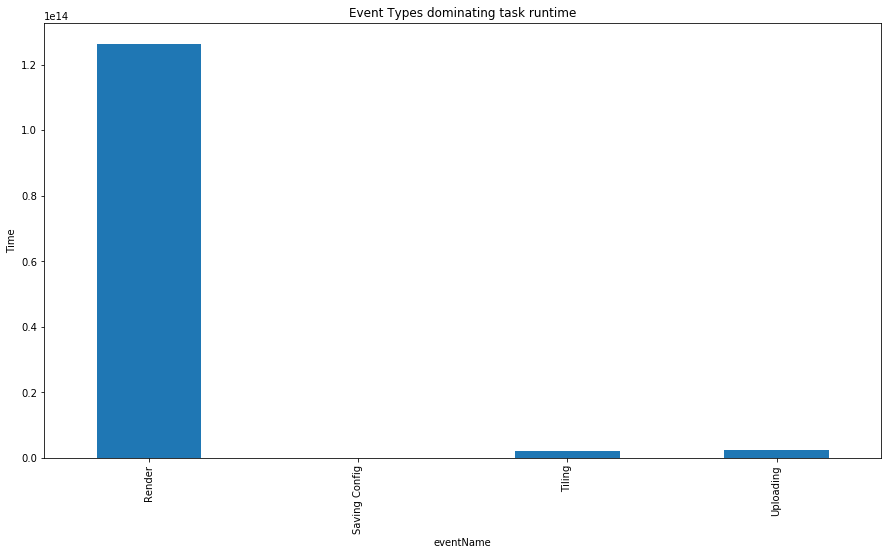

In [37]:
event_deltas = final_df[final_df['eventName'] != 'TotalRender'].groupby(
    ['eventName']).apply(lambda x: x.stop_time - x.start_time)

# sum execution times
event_deltas.groupby(['eventName']).sum().plot(kind = 'bar')

plt.ylabel('Time')
plt.title('Event Types dominating task runtime')
plt.rcParams['figure.figsize'] = [15, 8]

### It looks like rendering event took most of the time in GPU. Whereas saving configuration hardly had any impact on GPU

## No. of tasks assigned by GPU

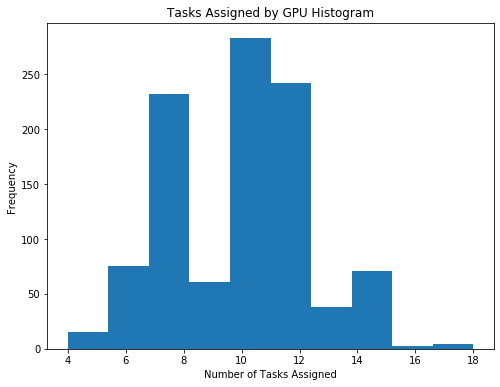

In [144]:
final_df['hostname'].value_counts().plot(kind = 'hist')
plt.xlabel('Number of Tasks Assigned')
plt.title('Tasks Assigned by GPU Histogram')

plt.rcParams['figure.figsize'] = [15, 8]


plt.show()

### The majority of GPUs are assigned 7 to 12 tasks on an average

## Distribution of GPU statistics

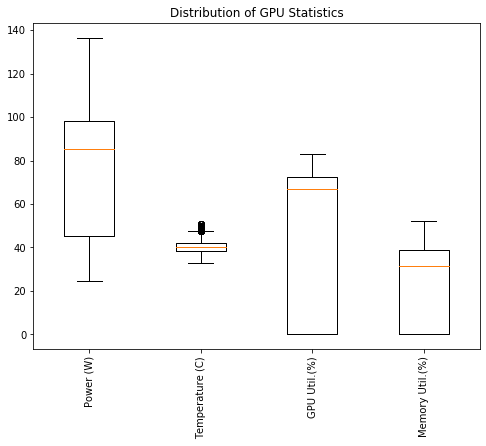

In [279]:

gpu_stats_labels = ['Power (W)','Temperature (C)','GPU Util.(%)','Memory Util.(%)']
plt.boxplot([final_df['powerDrawWatt'], final_df['gpuTempC'], 
             final_df['gpuUtilPerc'], final_df['gpuMemUtilPerc']])
plt.xticks([i+1 for i, _ in enumerate(gpu_stats_labels)],
           gpu_stats_labels, rotation='vertical')
plt.title('Distribution of GPU Statistics')
plt.rcParams['figure.figsize'] = [20, 8]

plt.show()

### The power consumption by the GPUs had an average of 80%, while the memory consumption and temperature were the least as in around 40C. The GPU utilisation was around 70% which seems to be decent enough

## Identify particular GPU cards (based on their serial numbers) whose performance differs to other cards? 

In [139]:
slower_gpu_df=final_df[(final_df['time_difference'] >= render_time_median)]
slower_gpu_hostname=slower_gpu_df.hostname
merged_df=gpu_data.merge(slower_gpu_df,on="hostname")
slower_gpu_df_sorted= slower_gpu_df.sort_values('time_difference', ascending=False)

In [176]:
top10_slowest=slower_gpu_df_sorted.nlargest(10,"time_difference")
top10_slowestgpu=top10_slowest["hostname"]

In [188]:
top10_slowestgpu

3259    0745914f4de046078517041d70b22fe7000009
3260    0745914f4de046078517041d70b22fe7000009
2595    6139a35676de44d6b61ec247f0ed865700001B
2596    6139a35676de44d6b61ec247f0ed865700001B
2987    2ecb9d8d51bc457aac88073f6da0546100000F
3183    04dc4e9647154250beeee51b866b0715000001
2988    2ecb9d8d51bc457aac88073f6da0546100000F
4730    b9a1fa7ae2f74eb68f25f607980f97d700000H
3184    04dc4e9647154250beeee51b866b0715000001
2935    83ea61ac1ef54f27a3bf7bd0f41ecaa7000011
Name: hostname, dtype: object

In [199]:
serial_gpu_data=gpu_data[["hostname","gpuSerial"]]

slowest_gpu_data=serial_gpu_data.merge(top10_slowestgpu.to_frame(),left_index=True, right_index=True)

# Top 10 slowest performing GPUs by their serial number

In [201]:
slowest_gpu_data["gpuSerial"]

2595    323617021242
2596    323617020414
2935    325017048638
2987    325217085174
2988    325017019589
3183    323617020145
3184    323617020179
3259    325117172395
3260    320118119713
4730    320218055639
Name: gpuSerial, dtype: int64

## Render event statistics

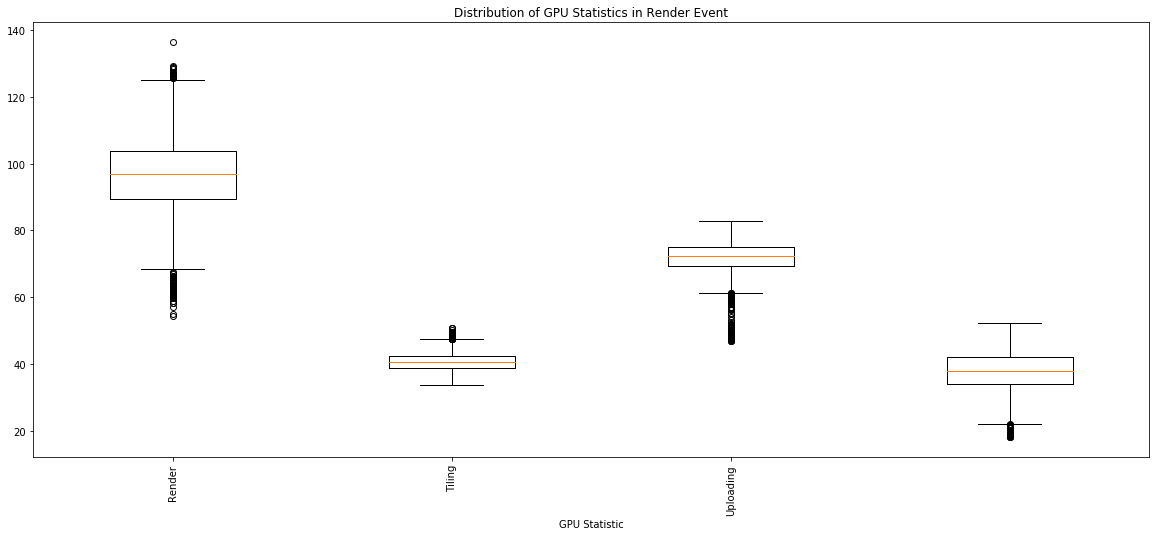

In [251]:

plt.boxplot(
    [final_df[final_df['eventName'] == 'Render']['powerDrawWatt'],
    final_df[final_df['eventName'] == 'Render']['gpuTempC'],
    final_df[final_df['eventName'] == 'Render']['gpuUtilPerc'],
    final_df[final_df['eventName'] == 'Render']['gpuMemUtilPerc']])
 
# setup labels and titles

plt.title('Distribution of GPU Statistics in Render Event')
plt.xlabel('GPU Statistic')
plt.xticks([i+1 for i, _ in enumerate(gpu_stats_labels)],
           gpu_stats_labels, rotation='vertical')


# draw plot

plt.rcParams['figure.figsize'] = [8, 6]
plt.show()

## Tiling event statistics

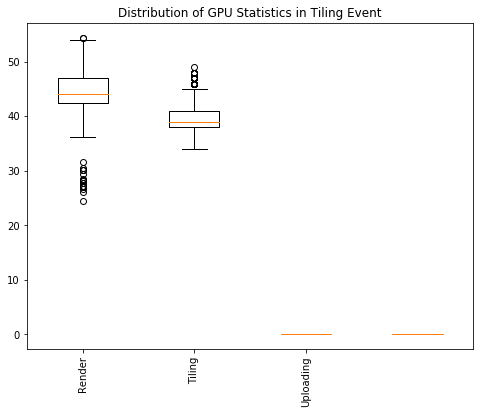

In [252]:


plt.boxplot(
    [final_df[final_df['eventName'] == 'Tiling']['powerDrawWatt'],
    final_df[final_df['eventName'] == 'Tiling']['gpuTempC'],
    final_df[final_df['eventName'] == 'Tiling']['gpuUtilPerc'],
    final_df[final_df['eventName'] == 'Tiling']['gpuMemUtilPerc']])
 
# setup labels and titles

plt.title('Distribution of GPU Statistics in Tiling Event')
plt.xticks([i+1 for i, _ in enumerate(gpu_stats_labels)],
           gpu_stats_labels, rotation='vertical')


# draw plot

plt.rcParams['figure.figsize'] = [8, 6]
plt.show()

## Uploading event statistics

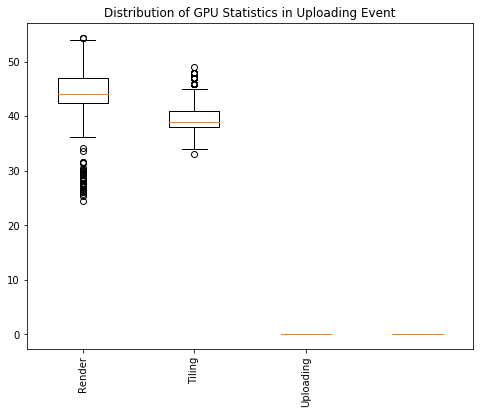

In [253]:
plt.boxplot(
    [final_df[final_df['eventName'] == 'Uploading']['powerDrawWatt'],
     final_df[final_df['eventName'] == 'Uploading']['gpuTempC'],
     final_df[final_df['eventName'] == 'Uploading']['gpuUtilPerc'],
     final_df[final_df['eventName'] == 'Uploading']['gpuMemUtilPerc']])
 
# setup labels and titles

plt.title('Distribution of GPU Statistics in Uploading Event')
plt.xticks([i+1 for i, _ in enumerate(gpu_stats_labels)],
           gpu_stats_labels, rotation='vertical')


# draw plot

plt.rcParams['figure.figsize'] = [8, 6]
plt.show()

## Interplay between GPU temperature and performance

In [273]:
# Calculating the median temperature of the GPU and creating two datasets with values above and below the median
temp_med = statistics.median(final_df['gpuTempC'])
below_med_temp = final_df[(final_df['gpuTempC'] <= temp_med) &(final_df['eventName'] == 'Render')].groupby(['eventName'])
above_med_temp = final_df[(final_df['gpuTempC'] >= temp_med) &(final_df['eventName'] == 'Render')].groupby(['eventName'])

Render    AxesSubplot(0.1,0.15;0.8x0.75)
dtype: object

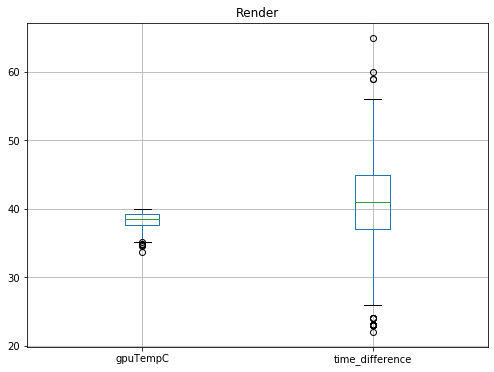

In [274]:
below_med_temp.boxplot(column=["gpuTempC","time_difference"])

Render    AxesSubplot(0.1,0.15;0.8x0.75)
dtype: object

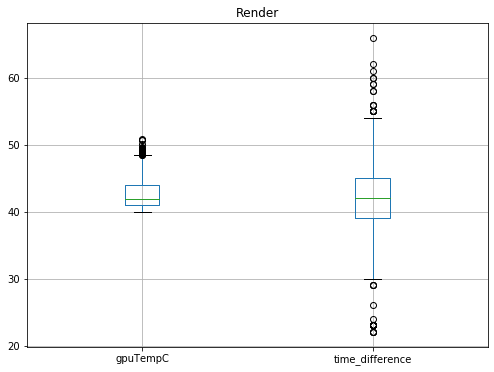

In [275]:
above_med_temp.boxplot(column=["gpuTempC","time_difference"])

## Interplay between increased power draw and render time

In [276]:
# Calculating the median power drawn of the GPU and creating two datasets with values above and below the median
power_med = statistics.median(final_df['powerDrawWatt'])
below_med_power = final_df[(final_df['powerDrawWatt'] <= power_med) &(final_df['eventName'] == 'Render')].groupby(['eventName'])
above_med_power = final_df[(final_df['powerDrawWatt'] >= power_med) &(final_df['eventName'] == 'Render')].groupby(['eventName'])

Render    AxesSubplot(0.1,0.15;0.8x0.75)
dtype: object

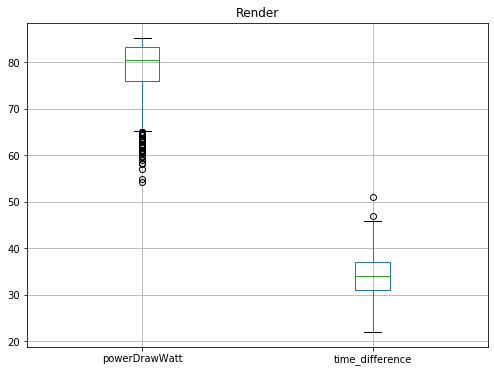

In [277]:
below_med_power.boxplot(column=["powerDrawWatt","time_difference"])

Render    AxesSubplot(0.1,0.15;0.8x0.75)
dtype: object

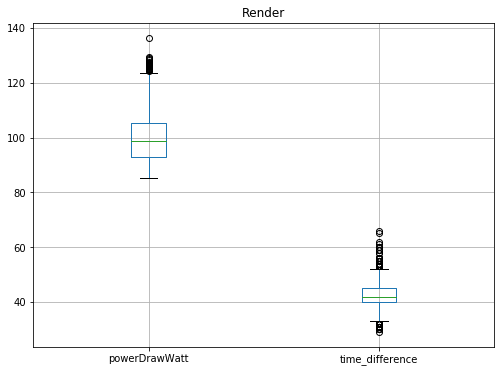

In [278]:
above_med_power.boxplot(column=["powerDrawWatt","time_difference"])

In [280]:
power_med

85.31480158730157